In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/Shareddrives/BidPrice/DataWarehouse'
!ls

/content/drive/Shareddrives/BidPrice/DataWarehouse
Agg_2_output.csv	     Combined_Basic_X_Range3.csv     Modified_2_output.csv
Agg_3_output.csv	     Combined_Basic_Y_Range2.csv     Modified_3_output.csv
AutogluonModels		     Combined_Basic_Y_Range3.csv     notices_processed.csv
Basic_2_output.csv	     Combined_Modified_X_Range2.csv  saved_model
Basic_3_output.csv	     Combined_Modified_X_Range3.csv  test_Combined_Modified_X_Range2.csv
bids_processed.csv	     Combined_Modified_Y_Range2.csv  test_Combined_Modified_Y_Range2.csv
catboost_info		     Combined_Modified_Y_Range3.csv  train_Combined_Modified_X_Range2.csv
Combined_Basic_X_Range2.csv  intervals			     train_Combined_Modified_Y_Range2.csv


In [ ]:
# Autogluon library 다운
!pip install autogluon -qU
print("Autogluon has been installed successfully.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.2/266.2 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.0/430.0 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.2/352.2 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

전처리 과정

In [ ]:
import random
random.seed(42)

In [15]:
bid_range = 2
data = pd.read_csv(f"/content/drive/Shareddrives/BidPrice/DataWarehouse/Modified_{bid_range}_output.csv")
X = data[['log_기초금액_norm', 'A값/기초금액_norm', '투찰률_norm', 'log_참여업체수_norm']]
Y = data.iloc[:,-180::]
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (1403, 4)
Y shape: (1403, 180)


In [9]:
data.isna().sum()

,0
공고번호,0
log_기초금액_norm,0
A값/기초금액_norm,0
투찰률_norm,0
log_참여업체수_norm,0
...,...
100_096,0
100_097,0
100_098,0
100_099,0


In [14]:
# Autogluon 관련
# from autogluon.tabular import TabularDataset, TabularPredictor

# scikit-learn 메트릭
from sklearn.metrics import r2_score, mean_squared_error

# Colab 환경이라 가정
# (만약 필요하다면) saved_model 디렉토리 생성
os.makedirs("saved_model", exist_ok=True)
# 데이터 로드
X = pd.read_csv("Modified_X_Range2.csv")
Y = pd.read_csv("Modified_Y_Range2.csv")
# 공고번호 제거
if "공고번호" in Y.columns:
    Y.drop("공고번호", axis=1, inplace=True)
# 예시: 필요한 컬럼 4개 선택
X = X[["log_기초금액_norm", "투찰률_norm","A값/기초금액_norm", "log_참여업체수_norm"]]
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'Modified_X_Range2.csv'

**항상, 중복된 데이터가 있는지 조사할 것**

In [5]:
# 1️⃣ 결측값이 있는 행 찾기 (투찰률_norm이 NaN인 행)
rows_to_delete = X[X['투찰률_norm'].isna()].index

# 2️⃣ X와 Y에서 동일한 행 삭제
X = X.drop(index=rows_to_delete)
Y = Y.drop(index=rows_to_delete)

NameError: name 'X' is not defined

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
# 1. train test dataset 분리 - 이후 저장까지 미리 해둘 것.
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)
train_X.to_csv("train_Combined_Modified_X_Range2.csv", index=False)
train_Y.to_csv("train_Combined_Modified_Y_Range2.csv", index=False)
test_X.to_csv("test_Combined_Modified_X_Range2.csv", index=False)
test_Y.to_csv("test_Combined_Modified_Y_Range2.csv", index=False)
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((1122, 4), (1122, 180), (281, 4), (281, 180))

In [21]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((1122, 4), (1122, 180), (281, 4), (281, 180))

## 발전 방향
1. (O)train test 분리 후 사용하도록 설정.
1. GPU를 사용해서 병렬처리를 도움
1. MSE 오차 등 여러 가지 오차를 함께 eval할 수 있도록
    results_list.append({
        'target': target_col,
        'best_model': best_model_name,
        'r2_score_val': best_score,
        'mse_val': mse_val
    })

1. RF 등 모델에서 - 어떤 파라미터를 사용했는지 확인

In [ ]:
# 실제 target별 예시.
from autogluon.tabular import TabularPredictor, TabularDataset

# ✅ 예제: 첫 번째 타겟 컬럼 사용
target_example = train_Y.columns[20]
train_data = TabularDataset(pd.concat([train_X, train_Y[target_example]], axis=1).dropna())

# ✅ AutoGluon 모델 학습
predictor = TabularPredictor(
    label=target_example,
    problem_type="regression",
    eval_metric="r2"
).fit(
    train_data=train_data,
    hyperparameters="default",  # ✅ GPU 사용 가능 모델만 설정
    presets='medium_quality_faster_train'#"best_quality",  # ✅ 성능과 속도의 균형 유지
)

# ✅ 학습된 모델 저장
model_save_path = f"saved_model/{target_example}"
predictor.save(model_save_path)
print(f"✅ Model for [{target_example}] saved at: {model_save_path}")

No path specified. Models will be saved in: "AutogluonModels/ag-20250209_063504"
Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
Memory Avail:       48.82 GB / 50.99 GB (95.7%)
Disk Space Avail:   191.55 GB / 235.68 GB (81.3%)
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/AutogluonModels/ag-20250209_063504"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_011
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:               

✅ Model for [020_011] saved at: saved_model/020_011


# 2단계 진행상황
1개 target에 대한 11개 모델에 대한 검사 OK.
RF, Lagre LGBM, 그리고 K neighborsDist를 사용하기로 결정하였다.

앞으로의 방향:

1. Distribution을 3개로만 설정하여 - 결과를 살펴보기
1. 모델 자동경로 설정 -> 한꺼번에 access할 수 있도록, 180개 target을 위한 모델 생성하기

In [ ]:
# 1. Target -> 원하는 3개 모델만 설정
from autogluon.tabular import TabularPredictor, TabularDataset

# ✅ 1. 사용할 모델 지정 (AutoGluon 공식 모델명)
selected_models = {
    "RF": {},  # RandomForest
    "KNN": {},  # K-Nearest Neighbors (거리 기반)
    "GBM": {}  # Large LightGBM
}

# ✅ 2. 예제: 특정 타겟 컬럼 사용 (이전에 사용한 target_example)
target_example = train_Y.columns[20]  # 특정 타겟 선택
train_data = TabularDataset(pd.concat([train_X, train_Y[target_example]], axis=1).dropna())

# ✅ 3. AutoGluon 모델 학습 (선택한 3개 모델만 사용)
model_save_path = f"saved_model/{target_example}"
predictor = TabularPredictor(
    label=target_example,
    path=model_save_path,
    problem_type="regression",
    eval_metric="r2"
).fit(
    train_data=train_data,
    #hyperparameters=selected_models,  # ✅ RF, KNeighborsDist, LGBMLarge만 사용
    presets='medium_quality_faster_train',  # ✅ 성능과 속도의 균형 유지

)

# ✅ 4. 학습된 모델 저장
predictor.save(model_save_path)
print(f"✅ Model for [{target_example}] saved at: {model_save_path}")

# ✅ 5. 학습된 모델 목록 출력 (공식 AutoGluon 모델 이름)
model_names = predictor.model_names()
print(f"📌 Trained Models: {model_names}")


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
Memory Avail:       48.08 GB / 50.99 GB (94.3%)
Disk Space Avail:   191.45 GB / 235.68 GB (81.2%)
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_011"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_011
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49234.44 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Infer

✅ Model for [020_011] saved at: saved_model/020_011
📌 Trained Models: ['KNeighborsUnif', 'KNeighborsDist', 'LightGBMXT', 'LightGBM', 'RandomForestMSE', 'CatBoost', 'ExtraTreesMSE', 'NeuralNetFastAI', 'XGBoost', 'NeuralNetTorch', 'LightGBMLarge', 'WeightedEnsemble_L2']


In [29]:
train_X[train_X.index == 1108], train_Y[train_Y.index == 1108][11:30]

(      log_기초금액_norm  A값/기초금액_norm  투찰률_norm  log_참여업체수_norm
 1108       0.334945     -0.059801 -4.040694       -2.131418,
 Empty DataFrame
 Columns: [010_001, 010_002, 010_003, 010_004, 010_005, 010_006, 010_007, 010_008, 010_009, 010_010, 020_001, 020_002, 020_003, 020_004, 020_005, 020_006, 020_007, 020_008, 020_009, 020_010, 020_011, 020_012, 020_013, 020_014, 020_015, 020_016, 020_017, 020_018, 020_019, 020_020, 050_001, 050_002, 050_003, 050_004, 050_005, 050_006, 050_007, 050_008, 050_009, 050_010, 050_011, 050_012, 050_013, 050_014, 050_015, 050_016, 050_017, 050_018, 050_019, 050_020, 050_021, 050_022, 050_023, 050_024, 050_025, 050_026, 050_027, 050_028, 050_029, 050_030, 050_031, 050_032, 050_033, 050_034, 050_035, 050_036, 050_037, 050_038, 050_039, 050_040, 050_041, 050_042, 050_043, 050_044, 050_045, 050_046, 050_047, 050_048, 050_049, 050_050, 100_001, 100_002, 100_003, 100_004, 100_005, 100_006, 100_007, 100_008, 100_009, 100_010, 100_011, 100_012, 100_013, 100_014, 100

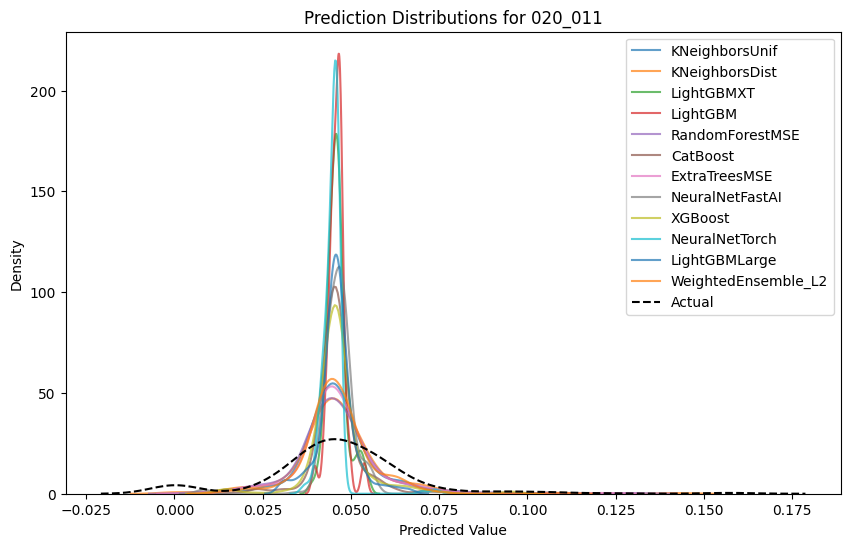

                  model  r2_score       mse      rmse       mae
0        KNeighborsUnif -0.233288  0.000564  0.023754  0.015659
1        KNeighborsDist -0.391069  0.000636  0.025227  0.016337
2            LightGBMXT -0.044251  0.000478  0.021857  0.014026
3              LightGBM -0.016514  0.000465  0.021565  0.013829
4       RandomForestMSE -0.381553  0.000632  0.025141  0.015848
5              CatBoost -0.166155  0.000534  0.023098  0.014494
6         ExtraTreesMSE -0.367086  0.000625  0.025009  0.015807
7       NeuralNetFastAI -0.066170  0.000488  0.022086  0.014473
8               XGBoost -0.208911  0.000553  0.023518  0.014533
9        NeuralNetTorch -0.025356  0.000469  0.021659  0.014004
10        LightGBMLarge -0.012280  0.000463  0.021520  0.013798
11  WeightedEnsemble_L2 -0.208661  0.000553  0.023515  0.015304


In [30]:
# ✅ 저장된 모델 경로
model_save_path = f"saved_model/020_011"  # 저장된 모델 위치 지정

# ✅ AutoGluon 모델 평가 실행
results_df = evaluate_saved_autogluon_model_target(
    model_save_path=model_save_path,
    test_X=test_X,
    test_Y=test_Y,
    target_example="020_011"  # 평가할 타겟 컬럼
)

# ✅ 평가 결과 출력
print(results_df)

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from autogluon.tabular import TabularPredictor

def evaluate_saved_autogluon_model_target(model_save_path, test_X, test_Y, target_example):
    """
    저장된 AutoGluon 모델을 로드하여 평가하는 함수.

    Args:
        model_save_path (str): 저장된 AutoGluon 모델 경로.
        test_X (DataFrame): 테스트 데이터 (입력).
        test_Y (DataFrame): 테스트 데이터 (출력, 실제값).
        target_example (str): 평가할 타겟 변수명.

    Returns:
        pd.DataFrame: 모델별 평가 결과 DataFrame.
    """

    # ✅ 1. 저장된 AutoGluon 모델 로드
    predictor = TabularPredictor.load(model_save_path)
    model_names = predictor.model_names()  # 학습된 모델 리스트 가져오기

    #print(f"✅ Loaded AutoGluon Predictor from {model_save_path}")
    #print(f"📌 Available Models: {model_names}")

    # ✅ 2. 테스트 데이터 준비
    y_true = test_Y[target_example].values  # 실제값

    # ✅ 3. 평가 결과 저장 리스트 및 예측값 저장 딕셔너리
    evaluation_results = []
    predictions = {}

    for model in model_names:
        #print(f"\n=== Evaluating Model: {model} ===")

        try:
            # ✅ 3-1. 모델별 예측 수행
            y_pred = predictor.predict(test_X, model=model).values

            # ✅ 3-2. 성능 지표 계산
            r2 = r2_score(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)

            # print(f"📌 Model: {model}")
            # print(f"📌 R² Score: {r2:.4f}")
            # print(f"📌 MSE: {mse:.4f}")
            # print(f"📌 RMSE: {rmse:.4f}")
            # print(f"📌 MAE: {mae:.4f}")

            # ✅ 3-3. 결과 저장
            evaluation_results.append({
                "model": model,
                "r2_score": r2,
                "mse": mse,
                "rmse": rmse,
                "mae": mae
            })

            # ✅ 3-4. 모델별 예측값 저장 (비교용)
            predictions[model] = y_pred

        except Exception as e:
            print(f"❌ Error evaluating {model}: {e}")
            continue  # 에러 발생 시 다음 모델 평가 진행

    # ✅ 4. 평가 결과 DataFrame 생성
    results_df = pd.DataFrame(evaluation_results)

    # ✅ 5. 결과 저장 경로 설정
    target_output_dir = os.path.join(model_save_path)
    os.makedirs(target_output_dir, exist_ok=True)

    results_csv_path = os.path.join(target_output_dir, "evaluation_results.csv")
    results_df.to_csv(results_csv_path, index=False)

    #print("\n=== ✅ Evaluation Complete ===")
    #print(f"📂 Results saved at: {results_csv_path}")

    # ✅ 6. 예측값 비교 그래프 (각 모델별 비교)
    plt.figure(figsize=(10, 6))

    for model, y_pred in predictions.items():
        sns.kdeplot(y_pred, label=model, alpha=0.7)

    sns.kdeplot(y_true, label="Actual", color="black", linestyle="--")
    plt.title(f"Prediction Distributions for {target_example}")
    plt.xlabel("Predicted Value")
    plt.ylabel("Density")
    plt.legend()
    plt.savefig(os.path.join(target_output_dir, "prediction_distribution.png"))
    plt.show()

    # ✅ 7. 각 모델별 예측 vs 실제값 비교 그래프 저장
    for model, y_pred in predictions.items():
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
        plt.title(f"Actual vs Predicted for {target_example} ({model})")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.savefig(os.path.join(target_output_dir, f"{model}_prediction_plot.png"))
        plt.close()

    return results_df


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from autogluon.tabular import TabularPredictor

def evaluate_saved_autogluon_models(model_save_path, test_X, test_Y, target_example, kde = False, scatter = True):
    """
    저장된 AutoGluon 모델을 로드하여 평가하는 함수 (Scatter Plot 추가).

    Args:
        model_save_path (str): 저장된 AutoGluon 모델 경로.
        test_X (DataFrame): 테스트 데이터 (입력).
        test_Y (DataFrame): 테스트 데이터 (출력, 실제값).
        target_example (str): 평가할 타겟 변수명.

    Returns:
        pd.DataFrame: 모델별 평가 결과 DataFrame.
    """

    # ✅ 1. 저장된 AutoGluon 모델 로드
    predictor = TabularPredictor.load(model_save_path)
    model_names = predictor.model_names()  # 학습된 모델 리스트 가져오기

    # ✅ 2. 테스트 데이터 준비
    y_true = test_Y[target_example].values  # 실제값

    # ✅ 3. 평가 결과 저장 리스트 및 예측값 저장 딕셔너리
    evaluation_results = []
    predictions = {}

    for model in model_names:
        try:
            # ✅ 3-1. 모델별 예측 수행
            y_pred = predictor.predict(test_X, model=model).values

            # ✅ 3-2. 성능 지표 계산
            r2 = r2_score(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)

            # ✅ 3-3. 결과 저장
            evaluation_results.append({
                "model": model,
                "r2_score": r2,
                "mse": mse,
                "rmse": rmse,
                "mae": mae
            })

            # ✅ 3-4. 모델별 예측값 저장 (비교용)
            predictions[model] = y_pred

        except Exception as e:
            print(f"❌ Error evaluating {model}: {e}")
            continue  # 에러 발생 시 다음 모델 평가 진행

    # ✅ 4. 평가 결과 DataFrame 생성
    results_df = pd.DataFrame(evaluation_results)

    # ✅ 5. 결과 저장 경로 설정
    target_output_dir = os.path.join(model_save_path)
    os.makedirs(target_output_dir, exist_ok=True)

    results_csv_path = os.path.join(target_output_dir, "evaluation_results.csv")
    results_df.to_csv(results_csv_path, index=False)

    # ✅ 6. 예측값 비교 그래프 (각 모델별 비교)
    plt.figure(figsize=(10, 6))

    for model, y_pred in predictions.items():
        sns.kdeplot(y_pred, label=model, alpha=0.7)
    if kde:
        sns.kdeplot(y_true, label="Actual", color="black", linestyle="--")
        plt.title(f"Prediction Distributions for {target_example}")
        plt.xlabel("Predicted Value")
        plt.ylabel("Density")
        plt.legend()
        plt.savefig(os.path.join(target_output_dir, "prediction_distribution.png"))
        plt.show()

    # ✅ 7. 모든 모델을 한 번에 비교하는 Scatter Plot 생성
    plt.figure(figsize=(8, 8))
    for model, y_pred in predictions.items():
        plt.scatter(y_true, y_pred, alpha=0.5, label=model, s=6)

    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.title(f"Actual vs Predicted Comparison ({target_example})")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.savefig(os.path.join(target_output_dir, "scatter_comparison.png"))
    plt.show()

    for model, y_pred in predictions.items():
        plt.scatter(y_true, y_pred, alpha=0.5, label=model, s=6)

        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
        plt.title(f"Actual vs Predicted Comparison ({target_example})")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        plt.savefig(os.path.join(target_output_dir, "scatter_comparison.png"))
        plt.show()
    # ✅ 8. 각 모델별 개별 Scatter Plot 저장
    for model, y_pred in predictions.items():
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
        plt.title(f"Actual vs Predicted for {target_example} ({model})")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.savefig(os.path.join(target_output_dir, f"{model}_prediction_plot.png"))
        plt.close()

    return results_df


2. 180개 반복하도록 설정!


In [32]:
# 1. Target -> 원하는 3개 모델만 설정
# del range
from autogluon.tabular import TabularPredictor, TabularDataset
n = 180
def run_model(n):

    # ✅ 1. 사용할 모델 지정 (AutoGluon 공식 모델명)
    selected_models = {
        "RF": {},  # RandomForest
        "KNN": {},  # K-Nearest Neighbors (거리 기반)
        "GBM": {}  # Large LightGBM
    }

    for num_column in range(n):
        # ✅ 2. 예제: 특정 타겟 컬럼 사용 (이전에 사용한 target_example)
        target_example = train_Y.columns[num_column]  # 특정 타겟 선택
        train_data = TabularDataset(pd.concat([train_X, train_Y[target_example]], axis=1).dropna())

        # ✅ 3. AutoGluon 모델 학습 (선택한 3개 모델만 사용)
        model_save_path = f"saved_model/{target_example}"
        predictor = TabularPredictor(
            label=target_example,
            path=model_save_path,
            problem_type="regression",
            eval_metric="r2"
        ).fit(
            train_data=train_data,
            hyperparameters=selected_models,  # ✅ RF, KNeighborsDist, LGBMLarge만 사용
            presets='medium_quality_faster_train'  # ✅ 성능과 속도의 균형 유지
        )

        # ✅ 4. 학습된 모델 저장
        predictor.save(model_save_path)
        print(f"✅ Model for [{target_example}] saved at: {model_save_path}")

        # ✅ 5. 학습된 모델 목록 출력 (공식 AutoGluon 모델 이름)
        model_names = predictor.model_names()
        print(f"📌 Trained Models: {model_names}")

isRun = input()
if isRun == 'y':
    n=180
    run_model(n)

Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
Memory Avail:       47.97 GB / 50.99 GB (94.1%)
Disk Space Avail:   191.40 GB / 235.68 GB (81.2%)
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/010_001"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       010_001
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49110.44 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Infer

✅ Model for [010_001] saved at: saved_model/010_001
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/010_002"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       010_002
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49105.70 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [010_002] saved at: saved_model/010_002
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/010_003"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       010_003
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49146.92 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [010_003] saved at: saved_model/010_003
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/010_004"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       010_004
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49147.09 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [010_004] saved at: saved_model/010_004
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/010_005"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       010_005
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49147.69 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [010_005] saved at: saved_model/010_005
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/010_006"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       010_006
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49171.74 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [010_006] saved at: saved_model/010_006
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/010_007"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       010_007
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49175.52 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [010_007] saved at: saved_model/010_007
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/010_008"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       010_008
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49149.18 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [010_008] saved at: saved_model/010_008
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/010_009"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       010_009
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49163.63 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [010_009] saved at: saved_model/010_009
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/010_010"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       010_010
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49146.37 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [010_010] saved at: saved_model/010_010
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_001"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_001
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49109.16 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_001] saved at: saved_model/020_001
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_002"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_002
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49135.55 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_002] saved at: saved_model/020_002
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_003"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_003
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49157.30 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_003] saved at: saved_model/020_003
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_004"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_004
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49147.05 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_004] saved at: saved_model/020_004
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_005"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_005
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49122.52 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_005] saved at: saved_model/020_005
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_006"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_006
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49146.76 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_006] saved at: saved_model/020_006
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_007"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_007
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49134.29 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_007] saved at: saved_model/020_007
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_008"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_008
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49139.49 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_008] saved at: saved_model/020_008
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_009"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_009
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49123.96 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_009] saved at: saved_model/020_009
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_010"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_010
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49110.87 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_010] saved at: saved_model/020_010
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


	0.0151	 = Validation score   (r2)
	0.57s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForest ...
	0.0986	 = Validation score   (r2)
	0.51s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'KNeighbors': 0.708, 'RandomForest': 0.292}
	0.2084	 = Validation score   (r2)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 1.55s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 3174.3 rows/s (225 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_011")
Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #

✅ Model for [020_011] saved at: saved_model/020_011
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_012"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_012
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49133.08 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_012] saved at: saved_model/020_012
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_013"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_013
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49150.68 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_013] saved at: saved_model/020_013
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_014"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_014
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49132.91 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_014] saved at: saved_model/020_014
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_015"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_015
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49157.94 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_015] saved at: saved_model/020_015
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_016"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_016
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49141.75 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_016] saved at: saved_model/020_016
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_017"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_017
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49134.02 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_017] saved at: saved_model/020_017
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_018"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_018
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49118.51 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_018] saved at: saved_model/020_018
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_019"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_019
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49133.40 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_019] saved at: saved_model/020_019
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/020_020"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       020_020
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49119.37 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [020_020] saved at: saved_model/020_020
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_001"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_001
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49142.45 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_001] saved at: saved_model/050_001
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_002"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_002
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49112.91 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_002] saved at: saved_model/050_002
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_003"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_003
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49150.19 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_003] saved at: saved_model/050_003
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_004"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_004
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49150.99 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_004] saved at: saved_model/050_004
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_005"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_005
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49135.51 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_005] saved at: saved_model/050_005
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_006"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_006
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49125.40 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_006] saved at: saved_model/050_006
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_007"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_007
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49123.94 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_007] saved at: saved_model/050_007
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_008"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_008
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49119.87 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_008] saved at: saved_model/050_008
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_009"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_009
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49054.80 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_009] saved at: saved_model/050_009
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_010"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_010
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49098.07 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_010] saved at: saved_model/050_010
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_011"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_011
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49077.32 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_011] saved at: saved_model/050_011
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_012"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_012
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49146.02 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_012] saved at: saved_model/050_012
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_013"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_013
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49142.36 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_013] saved at: saved_model/050_013
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_014"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_014
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49157.20 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_014] saved at: saved_model/050_014
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_015"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_015
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49188.77 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_015] saved at: saved_model/050_015
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_016"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_016
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49168.32 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_016] saved at: saved_model/050_016
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_017"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_017
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49174.20 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_017] saved at: saved_model/050_017
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_018"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_018
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49176.02 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_018] saved at: saved_model/050_018
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_019"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_019
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49183.34 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_019] saved at: saved_model/050_019
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_020"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_020
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49164.68 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_020] saved at: saved_model/050_020
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_021"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_021
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49153.78 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_021] saved at: saved_model/050_021
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_022"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_022
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49174.14 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_022] saved at: saved_model/050_022
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_023"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_023
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49174.92 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_023] saved at: saved_model/050_023
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_024"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_024
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49157.62 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_024] saved at: saved_model/050_024
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_025"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_025
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49156.67 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_025] saved at: saved_model/050_025
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_026"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_026
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49151.12 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_026] saved at: saved_model/050_026
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_027"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_027
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49167.28 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_027] saved at: saved_model/050_027
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_028"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_028
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49165.45 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_028] saved at: saved_model/050_028
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_029"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_029
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49137.50 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_029] saved at: saved_model/050_029
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_030"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_030
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49143.62 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_030] saved at: saved_model/050_030
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_031"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_031
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49162.28 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_031] saved at: saved_model/050_031
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_032"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_032
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49160.74 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_032] saved at: saved_model/050_032
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_033"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_033
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49160.91 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_033] saved at: saved_model/050_033
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_034"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_034
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49186.11 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_034] saved at: saved_model/050_034
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_035"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_035
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49155.18 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_035] saved at: saved_model/050_035
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_036"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_036
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49142.87 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_036] saved at: saved_model/050_036
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_037"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_037
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49160.44 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_037] saved at: saved_model/050_037
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_038"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_038
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49156.81 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_038] saved at: saved_model/050_038
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_039"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_039
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49160.92 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_039] saved at: saved_model/050_039
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_040"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_040
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49169.14 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_040] saved at: saved_model/050_040
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_041"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_041
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49161.34 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_041] saved at: saved_model/050_041
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_042"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_042
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49168.23 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_042] saved at: saved_model/050_042
📌 Trained Models: ['KNeighbors', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_043"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_043
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49151.55 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_043] saved at: saved_model/050_043
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_044"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_044
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49177.38 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_044] saved at: saved_model/050_044
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_045"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_045
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49154.78 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_045] saved at: saved_model/050_045
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_046"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_046
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49161.19 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_046] saved at: saved_model/050_046
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_047"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_047
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49138.66 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_047] saved at: saved_model/050_047
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_048"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_048
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49164.46 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_048] saved at: saved_model/050_048
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_049"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_049
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49135.17 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_049] saved at: saved_model/050_049
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/050_050"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       050_050
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49170.10 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [050_050] saved at: saved_model/050_050
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_001"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_001
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49155.89 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_001] saved at: saved_model/100_001
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_002"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_002
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49167.68 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_002] saved at: saved_model/100_002
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_003"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_003
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49156.01 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_003] saved at: saved_model/100_003
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_004"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_004
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49151.14 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_004] saved at: saved_model/100_004
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_005"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_005
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49173.69 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_005] saved at: saved_model/100_005
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_006"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_006
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49153.57 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_006] saved at: saved_model/100_006
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_007"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_007
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49170.75 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_007] saved at: saved_model/100_007
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_008"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_008
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49135.13 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_008] saved at: saved_model/100_008
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_009"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_009
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49183.56 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_009] saved at: saved_model/100_009
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_010"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_010
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49165.73 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_010] saved at: saved_model/100_010
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_011"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_011
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49148.17 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_011] saved at: saved_model/100_011
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_012"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_012
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49176.45 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_012] saved at: saved_model/100_012
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_013"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_013
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49159.59 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_013] saved at: saved_model/100_013
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_014"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_014
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49764.14 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_014] saved at: saved_model/100_014
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_015"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_015
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49768.79 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_015] saved at: saved_model/100_015
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_016"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_016
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49763.10 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_016] saved at: saved_model/100_016
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_017"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_017
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49732.23 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_017] saved at: saved_model/100_017
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_018"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_018
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49726.87 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_018] saved at: saved_model/100_018
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_019"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_019
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49727.04 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_019] saved at: saved_model/100_019
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_020"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_020
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49728.75 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_020] saved at: saved_model/100_020
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_021"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_021
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49732.56 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_021] saved at: saved_model/100_021
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_022"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_022
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49758.71 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_022] saved at: saved_model/100_022
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_023"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_023
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49749.46 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_023] saved at: saved_model/100_023
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_024"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_024
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49726.64 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_024] saved at: saved_model/100_024
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_025"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_025
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49752.85 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_025] saved at: saved_model/100_025
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_026"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_026
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49740.58 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_026] saved at: saved_model/100_026
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_027"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_027
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49746.77 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_027] saved at: saved_model/100_027
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_028"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_028
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49735.84 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_028] saved at: saved_model/100_028
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_029"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_029
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49743.02 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_029] saved at: saved_model/100_029
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_030"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_030
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49726.92 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_030] saved at: saved_model/100_030
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_031"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_031
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49754.56 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_031] saved at: saved_model/100_031
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_032"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_032
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49740.50 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_032] saved at: saved_model/100_032
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_033"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_033
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49759.93 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_033] saved at: saved_model/100_033
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_034"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_034
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49740.05 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_034] saved at: saved_model/100_034
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_035"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_035
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49769.69 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_035] saved at: saved_model/100_035
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_036"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_036
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49739.44 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_036] saved at: saved_model/100_036
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_037"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_037
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49741.66 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_037] saved at: saved_model/100_037
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_038"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_038
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49752.51 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_038] saved at: saved_model/100_038
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_039"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_039
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49755.02 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_039] saved at: saved_model/100_039
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_040"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_040
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49733.30 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_040] saved at: saved_model/100_040
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_041"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_041
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49739.90 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_041] saved at: saved_model/100_041
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_042"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_042
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49730.11 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_042] saved at: saved_model/100_042
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_043"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_043
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49735.15 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_043] saved at: saved_model/100_043
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_044"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_044
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49746.48 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_044] saved at: saved_model/100_044
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_045"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_045
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49746.52 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_045] saved at: saved_model/100_045
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_046"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_046
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49737.37 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_046] saved at: saved_model/100_046
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_047"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_047
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49747.04 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_047] saved at: saved_model/100_047
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_048"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_048
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49708.13 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_048] saved at: saved_model/100_048
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_049"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_049
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49735.03 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_049] saved at: saved_model/100_049
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_050"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_050
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49756.72 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_050] saved at: saved_model/100_050
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_051"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_051
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49723.44 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_051] saved at: saved_model/100_051
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_052"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_052
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49739.67 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_052] saved at: saved_model/100_052
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_053"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_053
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49715.22 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_053] saved at: saved_model/100_053
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_054"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_054
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49754.96 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_054] saved at: saved_model/100_054
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_055"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_055
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49731.69 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_055] saved at: saved_model/100_055
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_056"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_056
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49758.10 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_056] saved at: saved_model/100_056
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_057"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_057
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49736.42 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_057] saved at: saved_model/100_057
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_058"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_058
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49753.96 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_058] saved at: saved_model/100_058
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_059"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_059
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49747.75 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_059] saved at: saved_model/100_059
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_060"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_060
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49730.06 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_060] saved at: saved_model/100_060
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_061"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_061
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49731.12 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_061] saved at: saved_model/100_061
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_062"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_062
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49742.56 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_062] saved at: saved_model/100_062
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_063"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_063
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49750.60 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_063] saved at: saved_model/100_063
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_064"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_064
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49774.28 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_064] saved at: saved_model/100_064
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_065"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_065
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49755.19 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_065] saved at: saved_model/100_065
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_066"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_066
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49749.50 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_066] saved at: saved_model/100_066
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_067"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_067
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49744.23 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_067] saved at: saved_model/100_067
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_068"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_068
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49756.71 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_068] saved at: saved_model/100_068
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_069"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_069
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49752.37 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_069] saved at: saved_model/100_069
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_070"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_070
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49767.95 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_070] saved at: saved_model/100_070
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_071"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_071
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49744.17 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_071] saved at: saved_model/100_071
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_072"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_072
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49735.72 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_072] saved at: saved_model/100_072
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_073"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_073
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49722.05 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_073] saved at: saved_model/100_073
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_074"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_074
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49720.33 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_074] saved at: saved_model/100_074
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_075"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_075
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49736.72 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_075] saved at: saved_model/100_075
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_076"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_076
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49743.89 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_076] saved at: saved_model/100_076
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_077"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_077
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49733.73 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_077] saved at: saved_model/100_077
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_078"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_078
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49738.75 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_078] saved at: saved_model/100_078
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_079"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_079
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49726.76 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_079] saved at: saved_model/100_079
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_080"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_080
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49719.91 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_080] saved at: saved_model/100_080
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_081"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_081
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49724.42 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_081] saved at: saved_model/100_081
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_082"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_082
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49700.36 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_082] saved at: saved_model/100_082
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_083"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_083
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49734.69 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_083] saved at: saved_model/100_083
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_084"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_084
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49746.74 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_084] saved at: saved_model/100_084
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_085"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_085
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49693.23 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_085] saved at: saved_model/100_085
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_086"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_086
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49739.31 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_086] saved at: saved_model/100_086
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_087"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_087
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49741.02 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_087] saved at: saved_model/100_087
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_088"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_088
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49747.33 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_088] saved at: saved_model/100_088
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_089"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_089
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49735.39 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_089] saved at: saved_model/100_089
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_090"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_090
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49750.02 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_090] saved at: saved_model/100_090
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_091"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_091
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49730.40 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_091] saved at: saved_model/100_091
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_092"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_092
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49738.25 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_092] saved at: saved_model/100_092
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_093"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_093
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49728.10 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_093] saved at: saved_model/100_093
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_094"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_094
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49721.13 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_094] saved at: saved_model/100_094
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_095"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_095
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49690.14 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_095] saved at: saved_model/100_095
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_096"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_096
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49715.36 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_096] saved at: saved_model/100_096
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_097"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_097
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49715.14 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_097] saved at: saved_model/100_097
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_098"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_098
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49719.81 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_098] saved at: saved_model/100_098
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_099"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_099
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49710.22 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_099] saved at: saved_model/100_099
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/Shareddrives/BidPrice/DataWarehouse/saved_model/100_100"
Train Data Rows:    1122
Train Data Columns: 4
Label Column:       100_100
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    49717.23 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) :

✅ Model for [100_100] saved at: saved_model/100_100
📌 Trained Models: ['KNeighbors', 'LightGBM', 'RandomForest', 'WeightedEnsemble_L2']


In [ ]:
# 전체 실행 결과 확인
# ✅ 저장된 모델 경로
n = 180
for num_column in range(n):
    target_example = Y.columns[num_column]
    model_save_path = f"saved_model/{target_example}"  # 저장된 모델 위치 지정
    # ✅ AutoGluon 모델 평가 실행
    result_df = evaluate_saved_autogluon_models(
        model_save_path=model_save_path,
        test_X=test_X,
        test_Y=test_Y,
        target_example=target_example  # 평가할 타겟 컬럼
    )
    # ✅ 평가 결과 출력
    print(result_df)

Output hidden; open in https://colab.research.google.com to view.